# MVA - Geometric Data Analysis project - Eugène Berta - Yannis Cattan

This notebook is directly derived from an original one, written by Jean Feydy, and made available at https://jeanfeydy.com/Teaching/DataScience/gradient_flows.html 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import multivariate_normal

In [2]:
# Import the automatic differentiation + GPU toolbox
import torch
use_cuda = torch.cuda.is_available() # Shall we use the GPU?
tensor   = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtype    = tensor

# Let's keep things fast by default. Feel free to increase!
NPOINTS = 500 if use_cuda else 200
numpy = lambda x : x.detach().cpu().numpy()

In [3]:
use_cuda

True

In [4]:
# Generate curved distributions :

thetax = np.pi*np.random.rand(NPOINTS, 1)
rx = .8 + .2*np.random.rand(NPOINTS, 1)
thetay = -np.pi*np.random.rand(NPOINTS, 1)
ry = .8 + .2*np.random.rand(NPOINTS, 1)

x = np.hstack((np.cos(thetax)*rx + 0.5, np.sin(thetax)*rx))
y = np.hstack((np.cos(thetay)*ry - 0.5, np.sin(thetay)*ry))

mini = min(np.min(x), np.min(y))
x = x - mini
y = y - mini

maxi = max(np.max(x), np.max(y))
x = (x/maxi)*0.8+0.1
y = (y/maxi)*0.8+0.1

α_i, x_i = torch.from_numpy(np.ones((NPOINTS, 1))/NPOINTS).cuda(), torch.from_numpy(x).cuda()
β_j, y_j = torch.from_numpy(np.ones((NPOINTS, 1))/NPOINTS).cuda(), torch.from_numpy(y).cuda()

In [5]:
def display_samples(ax, x, color, x_grad=None):
    x_ = x.data.cpu().numpy()
    ax.scatter( x_[:,0], x_[:,1], 1500 / len(x_), color=color)

    if x_grad is not None :
        g_ = -x_grad.data.cpu().numpy()
        ax.quiver( x_[:,0], x_[:,1], g_[:,0], g_[:,1], 
                    scale = .01, scale_units="dots", color="#5CBF3A", 
                    zorder=1, width=0.25/len(x_))

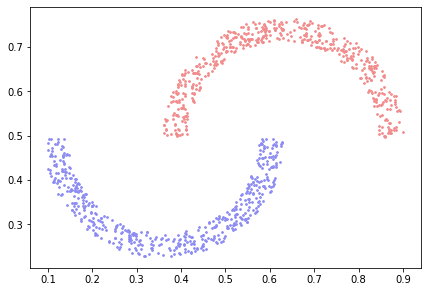

In [6]:
plt.figure(figsize=(7,7))

display_samples(plt.gca(), y_j, (.55,.55,.95))
display_samples(plt.gca(), x_i, (.95,.55,.55))

plt.axis("equal")
plt.gca().set_aspect('equal', adjustable='box')

In [7]:
def gradient_flow(α_i, x_i, β_j, y_j, cost, lr=.05) :
    """
    Flows along the gradient of the cost function, using a simple Euler scheme.
    
    Parameters
    ----------
        α_i : (N,1) torch tensor
            weights of the source measure
        x_i : (N,2) torch tensor
            samples of the source measure
        β_j : (M,1) torch tensor
            weights of the target measure
        y_j : (M,2) torch tensor
            samples of the target measure
        cost : (α_i,x_i,β_j,y_j) -> torch float number,
            real-valued function
        lr : float, default = .05
            learning rate, i.e. time step
    """
    
    # Parameters for the gradient descent
    Nsteps = int(5/lr)+1 
    t_plot      = np.linspace(-0.1, 1.1, 1000)[:,np.newaxis]
    display_its = [int(5*t/lr) for t in [0, .1, .2, 1]]
    
    # Make sure that we won't modify the input measures
    α_i, x_i, β_j, y_j = α_i.clone(), x_i.clone(), β_j.clone(), y_j.clone()

    # We're going to perform gradient descent on Cost(Alpha, Beta) 
    # wrt. the positions x_i of the diracs masses that make up Alpha:
    x_i.requires_grad_(True)  
    
    plt.figure(figsize=(20,5)) ; k = 1
    for i in range(Nsteps): # Euler scheme ===============
        # Compute cost and gradient
        loss = cost(α_i, x_i, β_j, y_j)
        [g]  = torch.autograd.grad(loss, [x_i])

        if i in display_its : # display
            ax = plt.subplot(1,4,k) ; k = k+1
            ax.scatter( [10], [10] ) # shameless hack

            display_samples(ax, y_j, (.55,.55,.95))
            display_samples(ax, x_i, (.95,.55,.55), g/α_i)
            
            ax.set_title("t = {:1.2f}".format(lr*i))
            ax.axis("equal") ; ax.axis([0,1,0.2,0.8])
            plt.xticks([], []); plt.yticks([], [])
            ax.set_aspect('equal', adjustable='box')
            
        # in-place modification of the tensor's values
        x_i.data -= lr * (g / α_i)

Kernel losses :

In [8]:
def KP(x,y,β_j, kernel = "gaussian", s = 1.) :
    """
    Computes K(x_i,y_j) @ β_j = \sum_j k(x_i-y_j) * β_j
    where k is a kernel function (say, a Gaussian) of deviation s.
    """
    x_i = x[:,None,:]  # Shape (N,d) -> Shape (N,1,d)
    y_j = y[None,:,:]  # Shape (M,d) -> Shape (1,M,d)
    xmy = x_i - y_j    # (N,M,d) matrix, xmy[i,j,k] = (x_i[k]-y_j[k])
    if   kernel == "gaussian" : K = torch.exp( - (xmy**2).sum(2) / (2*(s**2)) )
    elif kernel == "laplace"  : K = torch.exp( - xmy.norm(dim=2) / s )
    elif kernel == "energy"   : K = - xmy.norm(dim=2)
    return K @ β_j.view(-1,1) # Matrix-vector product

In [9]:
def KP_log(x,y,β_j_log, p = 2, blur = 1.) :
    x_i = x[:,None,:]  # Shape (N,d) -> Shape (N,1,d)
    y_j = y[None,:,:]  # Shape (M,d) -> Shape (1,M,d)
    xmy = x_i - y_j    # (N,M,d) matrix, xmy[i,j,k] = (x_i[k]-y_j[k])
    if   p==2 : C =  - (xmy**2).sum(2) / (2*(blur**2))
    elif p==1 : C =  - xmy.norm(dim=2) / blur
    return (blur**p)*(C + β_j_log.view(1,-1)).logsumexp(1,keepdim=True)

In [10]:
# PyTorch syntax for the L2 scalar product...
def scal(α, f) :
    return torch.dot(α.view(-1), f.view(-1))

def kernel_scalar_product(α_i, x_i, β_j, y_j, mode = "gaussian", s = 1.) :
    Kxy_β = KP(x_i,y_j,β_j,mode,s)
    return scal( α_i, Kxy_β ) 

In [11]:
def kernel_distance(mode = "gaussian", s = 1.) :
    def cost(α_i, x_i, β_j, y_j) :
        D2 =   (.5*kernel_scalar_product(α_i, x_i, α_i, x_i, mode,s) \
               +.5*kernel_scalar_product(β_j, y_j, β_j, y_j, mode,s) \
               -   kernel_scalar_product(α_i, x_i, β_j, y_j, mode,s) )
        return D2    
    return cost

Regularized OT loss :

In [12]:
D = lambda x : x.detach() # use the formula at convergence for the gradient

def ot_reg(p = 2, blur = .05, scaling=.5 ) :
    def cost(α_i, x_i, β_j, y_j) :
        # ε-scaling heuristic (aka. simulated annealing): 
        # let ε decrease across iterations, from 1 (=diameter) to the target value
        scales = [ tensor([np.exp(e)]) for e in 
                   np.arange(1, np.log(blur), np.log(scaling)) ] + [blur]
        
        # Solve the OT_ε(α,β) problem
        f_i, g_j = torch.zeros_like(α_i), torch.zeros_like(β_j)
        for scale in scales :
            g_j = -KP_log(y_j, D(x_i), D(f_i/scale**p + α_i.log()), p=p, blur=scale)
            f_i = -KP_log(x_i, D(y_j), D(g_j/scale**p + β_j.log()), p=p, blur=scale)
        
        # Return the dual cost OT_ε(α,β), assuming convergence in the Sinkhorn loop
        return scal(α_i, f_i) + scal(β_j, g_j)
    return cost

Sinkhorn loss :

In [13]:
def sinkhorn_divergence(p = 2, blur = .05, scaling=.5 ) :
    def cost(α_i, x_i, β_j, y_j) :
        # ε-scaling heuristic (aka. simulated annealing): 
        # let ε decrease across iterations, from 1 (=diameter) to the target value
        scales = [ tensor([np.exp(e)]) for e in 
                   np.arange(0, np.log(blur), np.log(scaling)) ] + [blur]
        
        # 1) Solve the OT_ε(α,β) problem
        f_i, g_j = torch.zeros_like(α_i), torch.zeros_like(β_j)
        for scale in scales :
            g_j = - KP_log(y_j, D(x_i), D(f_i/scale**p + α_i.log()), p=p, blur=scale)
            f_i = - KP_log(x_i, D(y_j), D(g_j/scale**p + β_j.log()), p=p, blur=scale)
        
        # 2) Solve the OT_ε(α,α) and OT_ε(β,β) problems
        scales_sym = [scale]*3 # Symmetric updates converge very quickly
        g_i, f_j = torch.zeros_like(α_i), torch.zeros_like(β_j)
        for scale in scales_sym :
            g_i=.5*(g_i - KP_log(x_i, x_i, g_i/scale**p + α_i.log(), p=p, blur=scale))
            f_j=.5*(f_j - KP_log(y_j, y_j, f_j/scale**p + β_j.log(), p=p, blur=scale))
        # Final step, to get a nice gradient in the backprop pass:
        g_i = - KP_log(x_i, D(x_i), D(g_i/scale**p + α_i.log()), p=p, blur=scale)
        f_j = - KP_log(y_j, D(y_j), D(f_j/scale**p + β_j.log()), p=p, blur=scale)
        
        # Return the "dual" cost :
        # S_ε(α,β) =        OT_ε(α,β)       - ½OT_ε(α,α) - ½OT_ε(β,β)
        #          = (〈α,f_αβ〉+〈β,g_αβ〉) -  〈α,g_αα〉 - 〈β,f_ββ〉
        return scal(α_i, f_i - g_i) + scal(β_j, g_j - f_j)
    return cost

Gradient flows for the teaser figure :

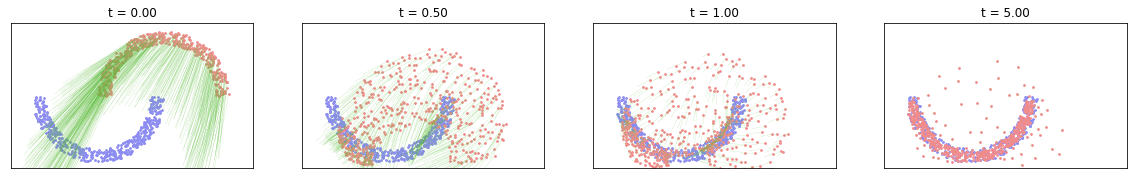

In [14]:
gradient_flow(α_i, x_i, β_j, y_j, kernel_distance("energy") )

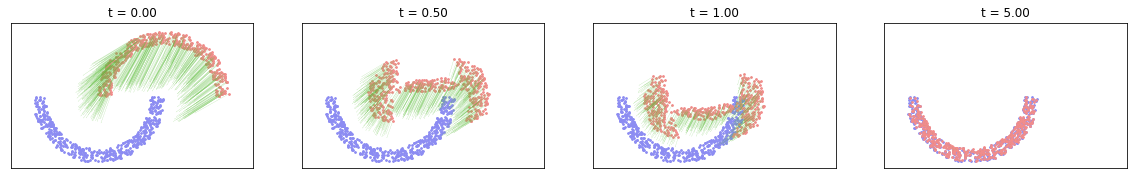

In [15]:
# We simulate a gradient flow with true OT using a very small epsilon
gradient_flow(α_i, x_i, β_j, y_j, ot_reg(p=2, blur=1e-8))

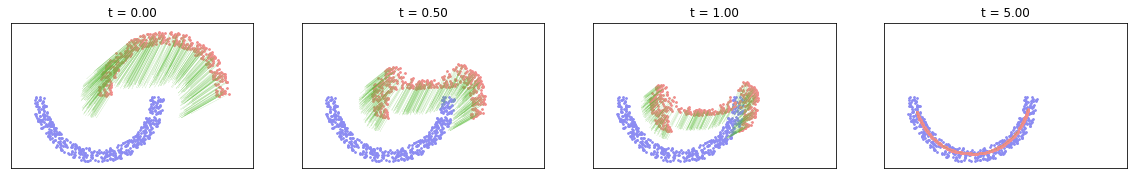

In [16]:
gradient_flow(α_i, x_i, β_j, y_j, ot_reg(p=2, blur=.05))

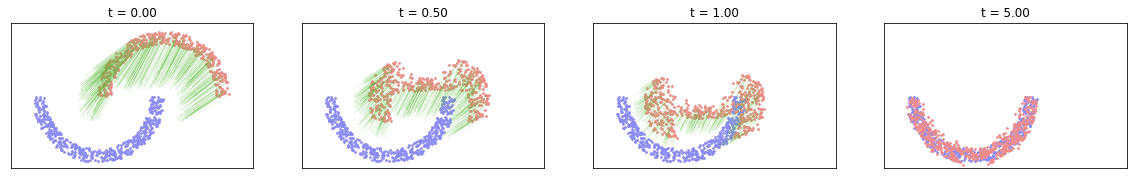

In [17]:
gradient_flow(α_i, x_i, β_j, y_j, sinkhorn_divergence(p=2, blur=.05))

Computing different losses at each step to compare the behaviours :

In [18]:
def figure1(α_i, x_i, β_j, y_j, cost_sinkhorn, cost_OT, cost_OTe, lr=.05):
    # Parameters for the gradient descent
    Nsteps = int(5/lr)+1 
    t_plot      = np.linspace(-0.1, 1.1, 1000)[:,np.newaxis]
    display_its = [int(5*t/lr) for t in [0, .1, .2, 1]]
    
    # Make sure that we won't modify the input measures
    α_i, x_i, β_j, y_j = α_i.clone(), x_i.clone(), β_j.clone(), y_j.clone()

    # We're going to perform gradient descent on Cost(Alpha, Beta) 
    # wrt. the positions x_i of the diracs masses that make up Alpha:
    x_i.requires_grad_(True)
    

    Loss_Se = []
    Loss_OT = []
    Loss_OTe = []
    Reg_OTe = []
    Reg_Se = []

    plt.figure(figsize=(20,5)) ; k = 1
    for i in range(Nsteps): # Euler scheme ===============
        # Compute cost and gradient
        loss = cost_OTe(α_i, x_i, β_j, y_j)
        loss_OT = cost_OT(α_i, x_i, β_j, y_j)
        loss_Se = cost_sinkhorn(α_i, x_i, β_j, y_j)

        Loss_Se.append(loss_Se.data.cpu().numpy())
        Loss_OT.append(loss_OT.data.cpu().numpy())
        Loss_OTe.append(loss.data.cpu().numpy())
        Reg_OTe.append(loss.data.cpu().numpy() - loss_OT.data.cpu().numpy())
        Reg_Se.append(loss_Se.data.cpu().numpy() - loss.data.cpu().numpy())

        [g]  = torch.autograd.grad(loss, [x_i])

        if i in display_its : # display
            ax = plt.subplot(1,4,k) ; k = k+1
            ax.scatter( [10], [10] ) # shameless hack

            display_samples(ax, y_j, (.55,.55,.95))
            display_samples(ax, x_i, (.95,.55,.55), g/α_i)
            
            ax.set_title("t = {:1.2f}".format(lr*i))
            ax.axis("equal") ; ax.axis([-1,2,-0.5,1.5])
            plt.xticks([], []); plt.yticks([], [])
            ax.set_aspect('equal', adjustable='box')
            
        # in-place modification of the tensor's values
        x_i.data -= lr * (g / α_i)
    
    return np.array(Loss_Se), np.array(Loss_OT), np.array(Loss_OTe), np.array(Reg_OTe), np.array(Reg_Se)

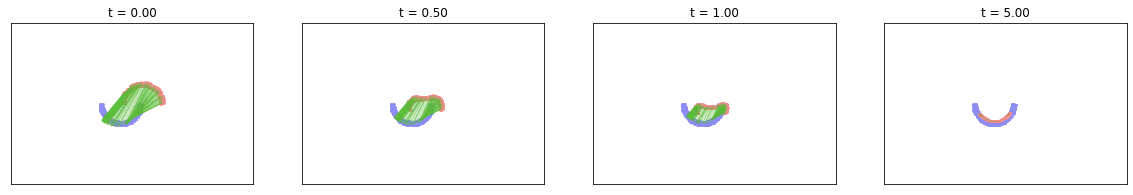

In [19]:
Loss_Se, Loss_OT, Loss_OTe, Reg_OTe, Reg_Se = figure1(α_i, x_i, β_j, y_j, sinkhorn_divergence(p=2, blur=.05), ot_reg(p=2, blur=1e-6), ot_reg(p=2, blur=.1))

The non-convex shape changes the analysis so we repeat the experiment with simpler distributions :

In [20]:
# Sampling from multivariate gaussians :
NPOINTS = 1000

alpha = multivariate_normal(np.array([0.8, 0.8]), 0.01*np.array([[10, 0],[0, 1]]))
beta = multivariate_normal(np.array([0.2, 0.2]), 0.01*np.array([[10, 0],[0, 1]]))

α_i, x_i = torch.from_numpy(np.ones((NPOINTS, 1))/NPOINTS).cuda(), torch.from_numpy(alpha.rvs(NPOINTS)).cuda()
β_j, y_j = torch.from_numpy(np.ones((NPOINTS, 1))/NPOINTS).cuda(), torch.from_numpy(beta.rvs(NPOINTS)).cuda()

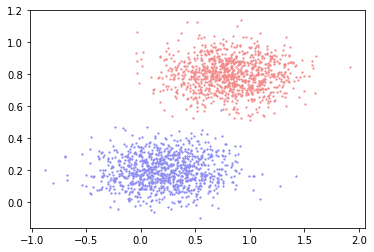

In [21]:
display_samples(plt.gca(), y_j, (.55,.55,.95))
display_samples(plt.gca(), x_i, (.95,.55,.55))

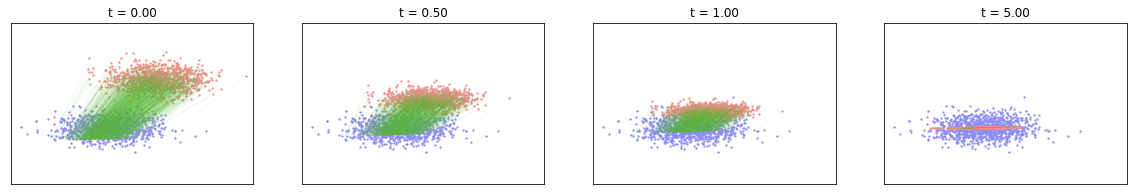

In [22]:
Loss_Se, Loss_OT, Loss_OTe, Reg_OTe, Reg_Se = figure1(α_i, x_i, β_j, y_j, sinkhorn_divergence(p=2, blur=.05), ot_reg(p=2, blur=1e-6), ot_reg(p=2, blur=.2))

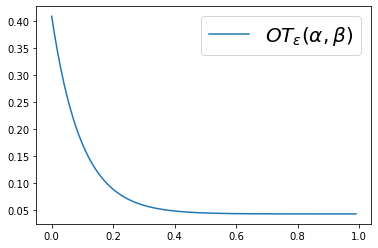

In [24]:
plt.plot(np.arange(0,1,1/len(Loss_Se)), Loss_OTe, label=r"$OT_\epsilon(\alpha, \beta)$")
plt.legend(fontsize=20)
plt.show()

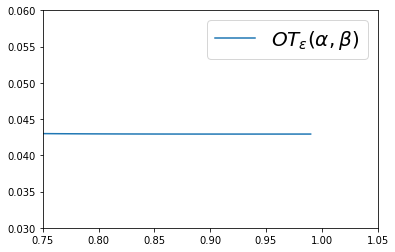

In [28]:
# Zoomed in :
plt.plot(np.arange(0,1,1/len(Loss_Se)), Loss_OTe, label=r"$OT_\epsilon(\alpha, \beta)$")
plt.axis([0.75,1.05,0.03,0.06])
#plt.xticks([], []); plt.yticks([], [])
plt.legend(fontsize=20)
plt.show()

We see that Sinkhorn mimics the true OT very well :

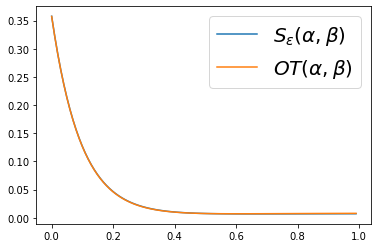

In [29]:
plt.plot(np.arange(0,1,1/len(Loss_Se)), Loss_Se, label=r"$S_\epsilon(\alpha, \beta)$")
plt.plot(np.arange(0,1,1/len(Loss_Se)), Loss_OT, label=r"$OT(\alpha, \beta)$")
plt.legend(fontsize=20)
plt.show()

We can vizualise the regularization terms that compensate each others :

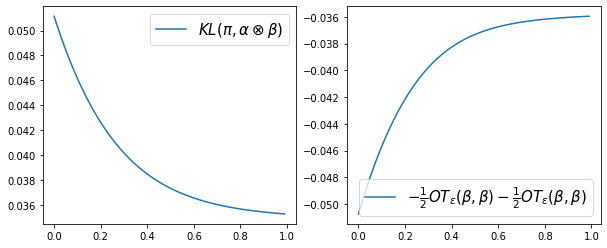

In [31]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(np.arange(0,1,1/len(Loss_Se)), Reg_OTe, label=r"$KL(\pi, \alpha \otimes \beta)$")
plt.legend(fontsize=15)

plt.subplot(122)
plt.plot(np.arange(0,1,1/len(Loss_Se)), Reg_Se, label=r"$-\frac{1}{2} OT_\epsilon(\beta, \beta) - \frac{1}{2} OT_\epsilon(\beta, \beta)$")
plt.legend(fontsize=15)

plt.show()

On the other hand, Sinkhorn and true OT are not maximized

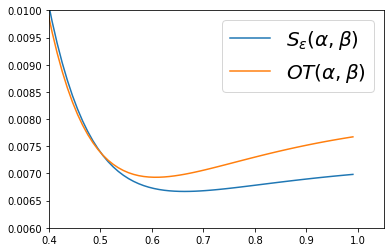

In [33]:
# Zoomed in :
#plt.figure(figsize=(10,8))
plt.plot(np.arange(0,1,1/len(Loss_Se)), Loss_Se, label=r"$S_\epsilon(\alpha, \beta)$")
plt.plot(np.arange(0,1,1/len(Loss_Se)), Loss_OT, label=r"$OT(\alpha, \beta)$")
plt.axis([0.4,1.05,0.006, 0.01])
plt.legend(fontsize=20)
plt.show()

New experiment to highlight the bias in regularized OT :

In [34]:
def figure2(cost_OT, cost_OTe, Nsteps=50):
    
    display_its = [0, 10, 25, 49]

    NPOINTS = 2000

    alpha = multivariate_normal(np.array([0,0]), np.eye(2)*0.15)
    beta = multivariate_normal(np.array([0,0]), np.eye(2)*0.1)

    α_i, x_i = torch.from_numpy(np.ones((NPOINTS, 1))/NPOINTS).cuda(), torch.from_numpy(alpha.rvs(NPOINTS)).cuda()
    β_j, y_j = torch.from_numpy(np.ones((NPOINTS, 1))/NPOINTS).cuda(), torch.from_numpy(beta.rvs(NPOINTS)).cuda()
    
    contracting = torch.from_numpy(0.99*np.eye(2)).cuda()

    Loss_OT = []
    Loss_OTe = []
    Reg_OTe = []

    plt.figure(figsize=(20,5)) ; k = 1
    for i in range(Nsteps): # Euler scheme ===============
        loss_OT = cost_OT(α_i, x_i, β_j, y_j)
        loss_OTe = cost_OTe(α_i, x_i, β_j, y_j)

        Loss_OT.append(loss_OT.data.cpu().numpy())
        Loss_OTe.append(loss_OTe.data.cpu().numpy())
        Reg_OTe.append(loss_OTe.data.cpu().numpy() - loss_OT.data.cpu().numpy())

        if i in display_its : # display
            ax = plt.subplot(1,4,k) ; k = k+1
            ax.scatter( [10], [10] )

            display_samples(ax, y_j, (.55,.55,.95))
            display_samples(ax, x_i, (.95,.55,.55))
            
            ax.set_title(f"t = {i/49:.2f}")
            ax.axis("equal") ; ax.axis([-1,1,-1,1])
            plt.xticks([], []); plt.yticks([], [])
            ax.set_aspect('equal', adjustable='box')
            
        # We contract the gaussian towards zero :
        x_i.data = torch.matmul(x_i.data, contracting)
    
    return np.array(Loss_OT), np.array(Loss_OTe), np.array(Reg_OTe)

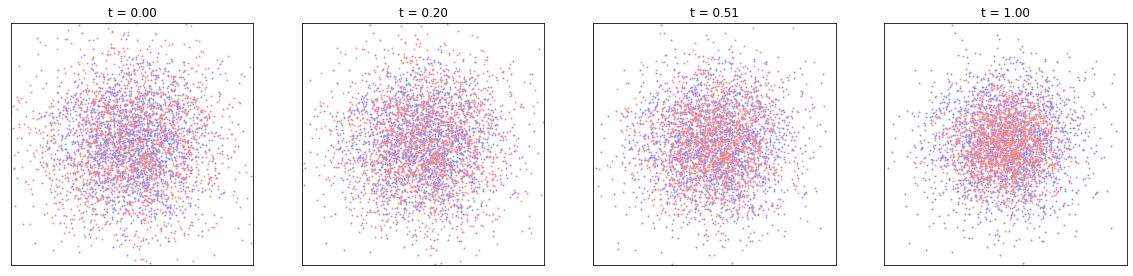

In [35]:
Loss_OT, Loss_OTe, Reg_OTe = figure2(ot_reg(p=2, blur=1e-6), ot_reg(p=2, blur=.1))

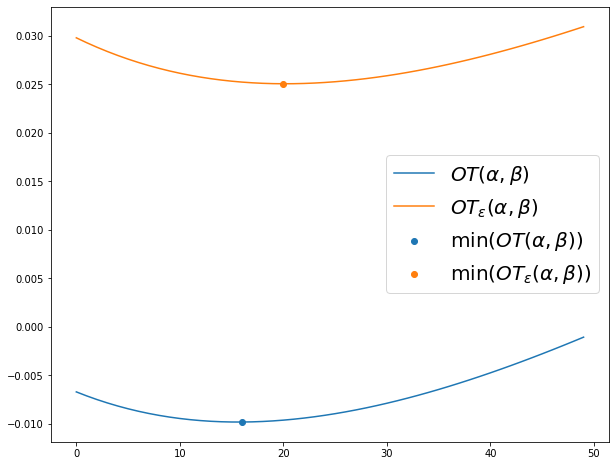

In [36]:
plt.figure(figsize=(10,8))

plt.plot(np.arange(len(Loss_OT)), Loss_OT, label=r"$OT(\alpha, \beta)$")
x, y = np.argmin(Loss_OT), np.min(Loss_OT)
plt.scatter(x, y, label=r"$\min(OT(\alpha, \beta))$")

plt.plot(np.arange(len(Loss_OT)), Loss_OTe, label=r"$OT_\epsilon(\alpha, \beta)$")
x, y = np.argmin(Loss_OTe), np.min(Loss_OTe)
plt.scatter(x, y, label=r"$\min(OT_\epsilon(\alpha, \beta))$")

plt.legend(fontsize=20)
plt.show()

This illustrates the bias that is introduced by the regularization term that we can plot :

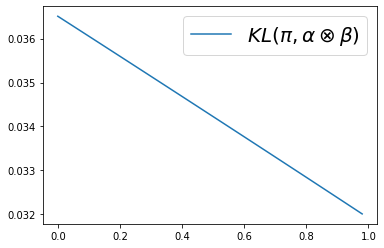

In [37]:
plt.plot(np.arange(0,1,1/len(Loss_OT)), Reg_OTe, label=r"$KL(\pi, \alpha \otimes \beta)$")
plt.legend(fontsize=20)
plt.show()

Simple figures to illustrate what is a geometric aware divergence :

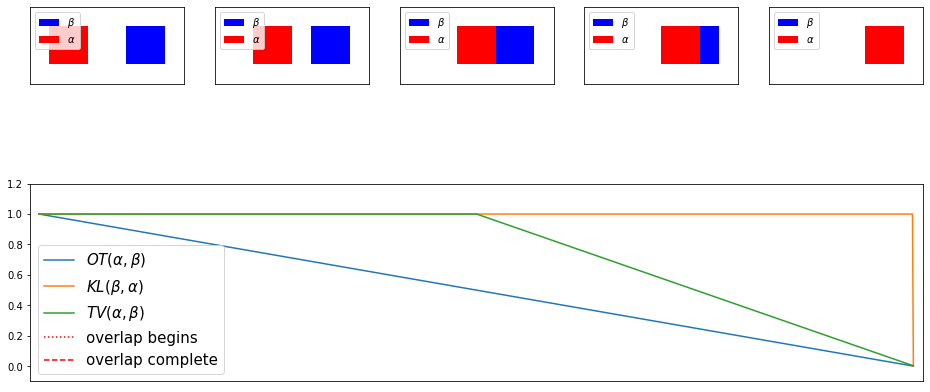

In [32]:
plt.figure(figsize=(16, 8))

for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    
    blue_square = plt.Rectangle((2,0), 1, 1, fc='blue', label=r'$\beta$')
    red_square = plt.Rectangle((2*i/4,0), 1, 1, fc='red', label=r'$\alpha$')
    
    ax.add_patch(blue_square)
    ax.add_patch(red_square)
    #ax.set_title(r'$TV(\alpha, \beta)=2$')
    ax.legend(loc="upper left")
    ax.axis("equal"); ax.axis([-0.5,3.5,-0.5,1.5])
    plt.xticks([], []); plt.yticks([], [])
    ax.set_aspect('equal', adjustable='box')

ax = plt.subplot(2,5,(6,10))

ax.plot([0,999], [1,0], label=r"$OT(\alpha,\beta)$")

KL_steps = np.ones(1000)
KL_steps[-1] = 0
ax.plot(range(len(KL_steps)), KL_steps, label=r"$KL(\beta, \alpha)$")

TV_steps = np.ones(1000)
TV_steps[500:] = np.arange(1,0,-1/500)
ax.plot(range(len(TV_steps)), TV_steps, label=r"$TV(\alpha, \beta)$")

ax.axvline(x = 500, ymin=0, ymax=0, color = 'r', linestyle='dotted', label='overlap begins')
ax.axvline(x = 998, ymin=0, ymax=0, color = 'r', linestyle='dashed', label='overlap complete')

ax.axis([-10,1010,-0.1,1.2])
plt.xticks([], [])
ax.legend(loc="lower left", fontsize=15)

plt.show()